In [1]:
import pandas
import numpy
import random

import matplotlib.pyplot as plt
import seaborn

from limit_order_book import (
    LimitOrder,
    ArrayDequeLimitOrderBook,
    Direction
)

# 1 Context

We explore a simple model to simulate the generation of limit orders in a limit order book.

### References

* Bouchaud, J. P., Mézard, M., & Potters, M. (2002). Statistical properties of stock order books: empirical results and models. Quantitative finance, 2(4), 251.
* Cont, R., Stoikov, S., & Talreja, R. (2010). A stochastic model for order book dynamics. Operations research, 58(3), 549-563.
* Gould, M. D., Porter, M. A., Williams, S., McDonald, M., Fenn, D. J., & Howison, S. D. (2013). Limit order books. Quantitative Finance, 13(11), 1709-1742.

# 2 Model

We suppose that limit orders are generated order-by-order and ignore the clock time between orders. We therefore consider "event time" denoted by $t$, i.e., $t=7$ means after 7 events.

At each $t$,
* either an order is generated or cancelled, the probability of an order being generated is $p_{generate}$
* the probability of the order being a bid rather than an ask is determined by the parameter $p_{bid}$
* the price of the order generated or cancelled is modelled by a power law over $n$ tick levels from the opposite best quote
* the size of the order is fixed at one lot (say, 100 shares)

Following Bouchard et. all (2002) and Cont et. al (2010) we utilise a power law to describe the arrival rate of events at each tick level $i$

$$ \lambda(i) = \frac{k}{i^{\alpha}} $$

Here, $k$ and $\alpha$ are parameters that can be determined from historical data. A different power law for order generation and order cancellation.

In [2]:
class LimitOrderBookSimulator:
    """Class to simulate events in a limit order book."""

    def __init__(
        self,
        p_bid,
        p_generate,
        depth,
        k_generate,
        alpha_generate,
        k_cancel,
        alpha_cancel
    ) -> None:
        self.p_bid = p_bid
        self.p_generate = p_generate
        self.depth = depth
        self.size = 100

        # Generate s
        self.ticks = numpy.arange(1, depth + 1)

        # Probs for order generation
        p_generate_by_tick = k_generate / (self.ticks ** alpha_generate)
        self.p_generate_by_tick = p_generate_by_tick / p_generate_by_tick.sum()
    
        # Probs for order cancellation
        p_cancel_by_tick = k_cancel / (self.ticks ** alpha_cancel)
        self.p_cancel_by_tick = p_cancel_by_tick / p_cancel_by_tick.sum()        

    def simulate(self, limit_order_book, n_events):
        """Simulate events"""

        for _ in range(n_events):
            self._simulate_event(limit_order_book)

    def _generate_order_generation_tick(self):
        """Generate tick level for order generation"""
        return numpy.random.choice(
                self.ticks,
                1,
                p=list(self.p_generate_by_tick)
        )[0] 

    def _generate_order_cancellation_tick(self):
        """Generate tick level for order cancellation""" 
        return numpy.random.choice(
            self.ticks,
            1,
            p=list(self.p_cancel_by_tick)
        )[0]
    
    def _simulate_event(self, limit_order_book):
        """Simulates a single event"""

        if random.random() < self.p_bid:
            # Bid

            # If no orders, suppose starting price is 5000
            opp_side = 5000 if lob.best_ask == 10001 else lob.best_ask
            
            if random.random() < self.p_generate:
                # Generate order
                draw = self._generate_order_generation_tick()               
                price = opp_side - draw + 1
                
                lo = LimitOrder(
                    price=price,
                    quantity=self.size,
                    trader_id=1,
                    direction=Direction.Buy
                )
        
                limit_order_book.add(lo)
            
            else:
                # Cancel order
                draw = self._generate_order_cancellation_tick()
                price = opp_side - draw + 1
    
                deque = lob._get_price_level(price)
                if len(deque) > 0:       
                    order_id = deque[0].id
                    limit_order_book.cancel(order_id)
        
        else:
            # Ask
            opp_side = 5000 if lob.best_bid == 0 else lob.best_bid
            
            if random.random() < self.p_generate:
                
                draw = self._generate_order_generation_tick()
                price = opp_side + draw - 1
                
                lo = LimitOrder(
                    price=price,
                    quantity=self.size,
                    trader_id=1,
                    direction=Direction.Sell
                )
        
                limit_order_book.add(lo)
        
            else:
                
                # Cancel order
                draw = self._generate_order_cancellation_tick()
                price = opp_side + draw -1
                
                deque = lob._get_price_level(price)
                if len(deque) > 0:       
                    order_id = deque[0].id
                    limit_order_book.cancel(order_id)

### Example

Let's simulate 10,000 events with the following parameters,

* $p_{generate} = 0.9$
* $p_{bid} = 0.5$
* $k_{generate} = 6.85$
* $\alpha_{generate} = 1.5$
* $k_{cancel} = 0.25$
* $\alpha_{cancel} = 3.0$
* $depth = 20$

In [3]:
lob_simulator = LimitOrderBookSimulator(
    p_bid = 0.5,
    p_generate=0.9,
    depth=20,
    k_generate=6.85,
    alpha_generate=1.5,
    k_cancel=0.25,
    alpha_cancel=3,
)

In [4]:
lob = ArrayDequeLimitOrderBook(name="Test", max_price=10000)

In [5]:
lob_simulator.simulate(lob, 10000)

We can examine the power laws..

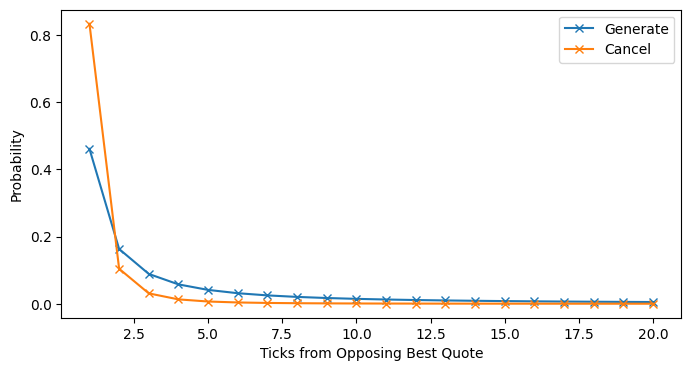

In [6]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))

plt.plot(lob_simulator.ticks, lob_simulator.p_generate_by_tick, label="Generate", marker='x')
plt.plot(lob_simulator.ticks, lob_simulator.p_cancel_by_tick, label="Cancel", marker='x')

plt.xlabel("Ticks from Opposing Best Quote")
plt.ylabel("Probability")
plt.legend();

We can examine the matched price over time

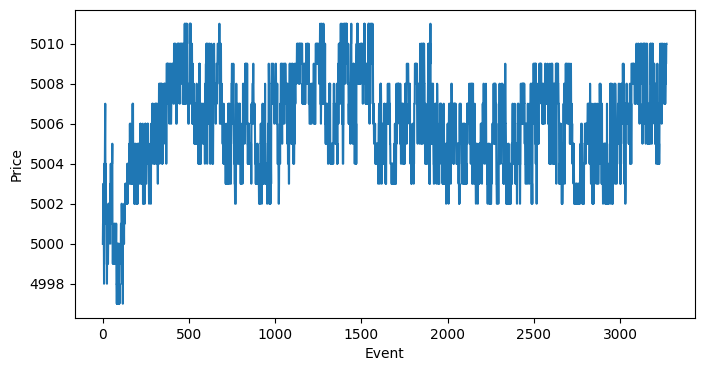

In [7]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))

matched_price = numpy.array([mo.price for mo in lob._matches])

ax.plot(matched_price)

ax.set_xlabel("Event")
ax.set_ylabel("Price");

We can also examine the order book depth at the end of the simulation..

In [8]:
df_lob = (
    pandas.concat([
        lob.get_top_bids_as_dataframe(levels=20).assign(Side="Bid"),
        lob.get_top_asks_as_dataframe(levels=20).assign(Side="Ask"),
    ], axis=0)
    .set_index(keys=["Price", "Side"])
    ["Quantity"]
    .unstack(1)
    .fillna(0)
)

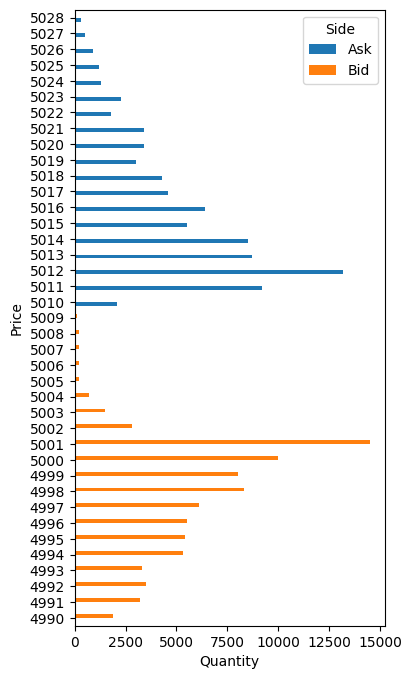

In [9]:
f, ax = plt.subplots(1, 1, figsize=(4, 8))

df_lob.plot(kind="barh", ax=ax)

ax.set_xlabel("Quantity")
ax.set_ylabel("Price");